### Load Data

In [1]:
household_id = 'idhogar'
target_column = 'Target'

from data_cleaning import get_training_data, get_test_data
train = get_training_data()

/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading data from data/train.csv...
(9557, 142)

Checking for inconsistent targets...
(85,)
(9557, 142)
Cleaning inconsistent targets...
Checking inconsistent targets are gone...
(0,)
(9557, 142)



Clean non-numerical data

In [2]:
import numpy as np
with np.errstate(divide='ignore'):
    train['dependency'] = train[['hogar_nin','hogar_mayor','hogar_adul']]\
        .apply(lambda row: min((row['hogar_nin']+row['hogar_mayor'])/(row['hogar_adul']-row['hogar_mayor']),8), axis=1)

In [3]:
train['edjefe'].replace('no','0',inplace=True)
train['edjefe'].replace('yes','1',inplace=True)
train['edjefe'] = train['edjefe'].astype('float')

In [4]:
train['edjefa'].replace('no','0',inplace=True)
train['edjefa'].replace('yes','1',inplace=True)
train['edjefa'] = train['edjefa'].astype('float')

### Feature Selection

Use household level features only

In [5]:
from column_categories import individuals_info, column_descriptions
household_columns = set(column_descriptions.keys()) - set(individuals_info)
household_df = train.reset_index()[list(household_columns)].drop(target_column, axis=1)

In [6]:
from data_cleaning import target_by_household
target_household_map = target_by_household(train)
target_household_map.head(2)

,Target
idhogar,
001ff74ca,4
003123ec2,2


In [7]:
household_df = household_df.groupby(household_id).first().drop('Id', axis=1)
# household_df = household_df.join(target_household_map)

In [8]:
X = household_df
y = target_household_map

In [9]:
nulls = train.isnull().sum(axis=0)
nulls[nulls!=0]/len(train)

v2a1         0.717798
v18q1        0.768233
rez_esc      0.829549
meaneduc     0.000523
SQBmeaned    0.000523
dtype: float64

In [10]:
X = household_df.drop(['v2a1','v18q1'], axis=1)

In [11]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X)
X_imp = imp.transform(X)
X_imp

array([[ 0.,  2.,  0., ...,  0., 16.,  1.],
       [ 0.,  1.,  1., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  2.,  1., ...,  0.,  6.,  2.]])

In [12]:
old_cols = list(range(len(X.columns.tolist())))
new_cols = X.columns.tolist()
cols = dict(zip(old_cols,new_cols))

In [13]:
old_idx = list(range(len(X)))
new_idx = X.index.tolist()
idx = dict(zip(old_idx,new_idx))

In [14]:
import pandas as pd
X_imp = pd.DataFrame(X_imp).rename(index=idx, columns=cols)

Use variance threshold to get only fetaures that are increasing or decreasing across classes

In [15]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.75 * (1 - .75)))

In [16]:
import pandas as pd
def format_selector(selector,data, target):
    # Fit the model
    selector.fit(data, target)
    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
    features = data[[data.columns.values[i] for i in features]]
    return features

In [17]:
reduced_df = format_selector(sel, X_imp, y)

In [18]:
desc = {k: column_descriptions[k] for k in reduced_df}
desc

{'r4m3': 'Total females in the household',
 'r4t2': 'persons 12 years of age and older',
 'r4h2': 'Males 12 years of age and older',
 'hogar_mayor': '# of individuals 65+ in the household',
 'tamviv': 'number of persons living in the household',
 'energcocinar3': '=1 main source of energy used for cooking gas',
 'overcrowding': '# persons per room',
 'r4h1': 'Males younger than 12 years of age',
 'SQBdependency': 'dependency squared',
 'etecho2': '=1 if roof are regular',
 'energcocinar2': '=1 main source of energy used for cooking electricity',
 'paredblolad': '=1 if predominant material on the outside wall is block or brick',
 'etecho3': '=1 if roof are good',
 'dependency': 'Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)',
 'SQBhogar_total': 'hogar_total squared',
 'epared2': '=1 if walls are regular',
 'r4h3': 'Total males in the household',
 'hogar_nin': 'Number of children 0 to 

In [19]:
def proportions(df):
    for col in df:
        df[col] =  df[col]/df[col].sum()
    return df

In [20]:
import seaborn as sns
sns.set()

def plot_breakdowns(X, desc):
    df = X[list(desc.keys())].join(target_household_map)
    if len(desc)==1:
        value = list(desc.keys())[0]
        desc['no '+value] = ''
        df['no '+value] = (~df[value].astype('bool')).astype('int')
    summed = df.groupby(target_column).sum()
    features_breakdown = proportions(summed.T).T
    features_breakdown.plot(kind='line', figsize=(12,6)).legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':10})
    return features_breakdown

,r4m3,r4t2,r4h2,hogar_mayor,tamviv,energcocinar3,overcrowding,r4h1,SQBdependency,etecho2,...,area2,area1,r4t1,SQBedjefe,tamhog,cielorazo,tipovivi1,hogar_adul,edjefa,r4m2
Target,,,,,,,,,,,,,,,,,,,,,
1,0.025740,0.019166,0.016379,0.016585,0.023751,0.025367,0.026715,0.042761,0.019617,0.029572,...,0.026717,0.019545,0.044536,0.007220,0.023415,0.013265,0.022145,0.018216,0.023207,0.021751
2,0.024251,0.021769,0.020924,0.027180,0.023809,0.024492,0.025954,0.032254,0.027937,0.027657,...,0.025195,0.020022,0.032628,0.009890,0.023566,0.015099,0.021832,0.020037,0.017628,0.022552
3,0.023434,0.022509,0.022046,0.025218,0.023092,0.023897,0.023771,0.025816,0.035542,0.028146,...,0.028381,0.018979,0.025900,0.013478,0.023050,0.018062,0.022879,0.021262,0.014011,0.022939
4,0.021086,0.022636,0.023258,0.021126,0.021493,0.020982,0.020500,0.016701,0.018559,0.018898,...,0.019774,0.023699,0.016385,0.028644,0.021599,0.025791,0.022195,0.023404,0.024808,0.022059


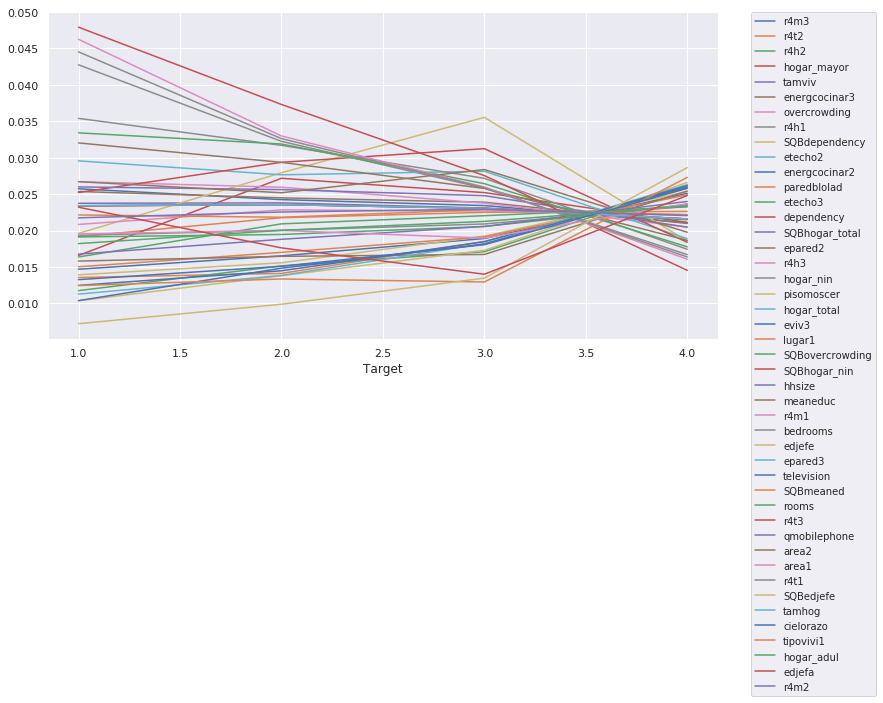

In [21]:
norm = X_imp.div(X_imp.sum(axis=0), axis=1)
plot_breakdowns(norm, desc)

### Train a SGDClassifier

In [28]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_imp, y)

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [30]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5957161981258366

In [33]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_valid)
print(classification_report(y_pred, y_valid))

             precision    recall  f1-score   support

          1       0.12      0.13      0.12        47
          2       0.13      0.24      0.17        66
          3       0.12      0.15      0.13        82
          4       0.85      0.74      0.80       552

avg / total       0.66      0.60      0.63       747



### Use SMOTE

In [34]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=13)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6024096385542169